# Домашняя работа №4

Выполнил: Хайкин Глеб, БЭК1812

Загрузим необходимые библиотеки:

In [2]:
library("readxl") # чтение excel-файла
library("tidyverse") # коллекция пакетов: ggplot2, dplyr, etc.
library("knitr") # создание отчётов

library("forecast") # прогнозирование временных рядов: ARMA и ETS модели
library("xts") # операции с временными рядами

library("tseries")

library("repr") # отрегулируем размер картинок
options(repr.plot.width=10, repr.plot.height=8)

## Части 1

При подготовке домашнего задания использовались квартальные данные с сайта [gks.ru](https://showdata.gks.ru/finder/):
* Валовой внутренний продукт в рыночных ценах в соответствии с методикой СНС 2008 (постоянные цены 2016 года) в качестве зависимой переменной;
* Налоги на продукты (постоянные цены 2016 года) в качестве независимой переменной.

In [3]:
df <- read_excel("data.xlsx")
head(df)

date,taxes,gdp
<dttm>,<dbl>,<dbl>
2011-03-25,2058370,18440083
2011-06-25,2217828,19714798
2011-09-25,2328577,20978424
2011-12-25,2455971,22617264
2012-03-25,2182464,19492308
2012-06-25,2297156,20672447


Будем использовать логарифмы для стабилизации дисперсии.

In [4]:
df$log_taxes = log(df$taxes)
df$log_gdp = log(df$gdp)

In [5]:
log_gdp_ts <- ts(df$log_gdp, start = c(2011, 1), freq = 4)
log_gdp_ts

,Qtr1,Qtr2,Qtr3,Qtr4
2011,16.73004,16.79688,16.85901,16.93422
2012,16.78553,16.84431,16.89336,16.95811
2013,16.79677,16.86137,16.90833,16.98324
2014,16.79629,16.86690,16.92228,16.99246
2015,16.78087,16.83549,16.90510,16.97633
2016,16.77881,16.83870,16.90568,16.98169
2017,16.79185,16.86187,16.93173,16.99206
2018,16.81715,16.88879,16.95774,17.02394
2019,16.82966,16.90068,16.98352,17.05205
2020,16.84332,16.81940,16.94833,17.03421


In [6]:
log_taxes_ts <- ts(df$log_taxes, start = c(2011, 1), freq = 4)
log_taxes_ts

,Qtr1,Qtr2,Qtr3,Qtr4
2011,14.53742,14.61204,14.66077,14.71403
2012,14.59596,14.64718,14.68636,14.73405
2013,14.61441,14.66276,14.70363,14.75231
2014,14.54100,14.64301,14.72567,14.74805
2015,14.52022,14.59374,14.63884,14.69409
2016,14.50263,14.58478,14.62940,14.69695
2017,14.51946,14.59845,14.66163,14.70036
2018,14.55088,14.63028,14.68016,14.73730
2019,14.56660,14.61364,14.71027,14.78942
2020,14.55866,14.51879,14.62510,14.75366


### Задание 1

Построим графики выбранных переменных. 

##### GDP

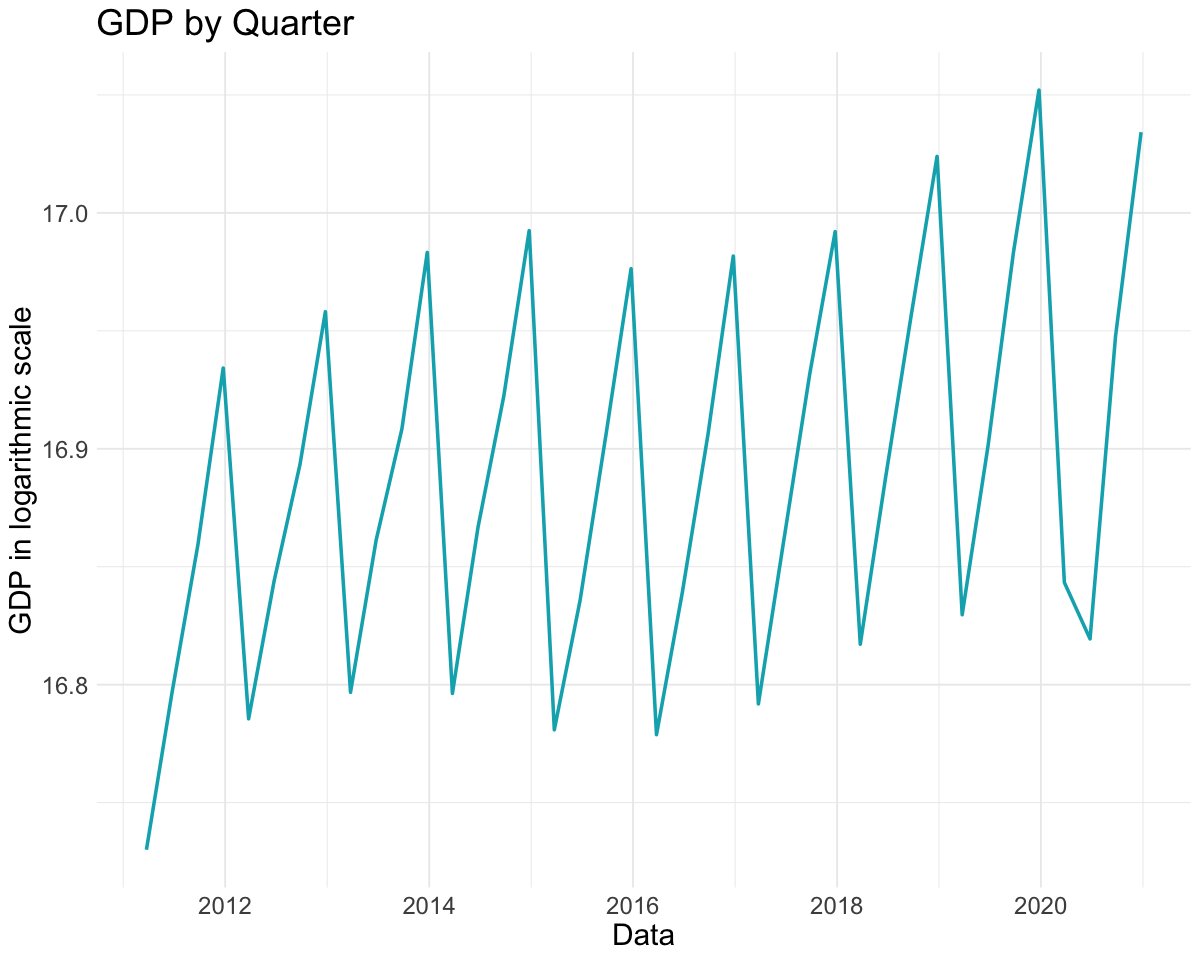

In [7]:
ggplot(data=df, aes(x = date, y = log_gdp))+
  geom_line(color = "#00AFBB", size = 1) + 
    labs(x = "Data",
         y = "GDP in logarithmic scale", 
         color = "") +
    theme_minimal() + 
    ggtitle("GDP by Quarter") + 
    theme(text = element_text(size=18))

Выделим тренд и сезонность у ряда.

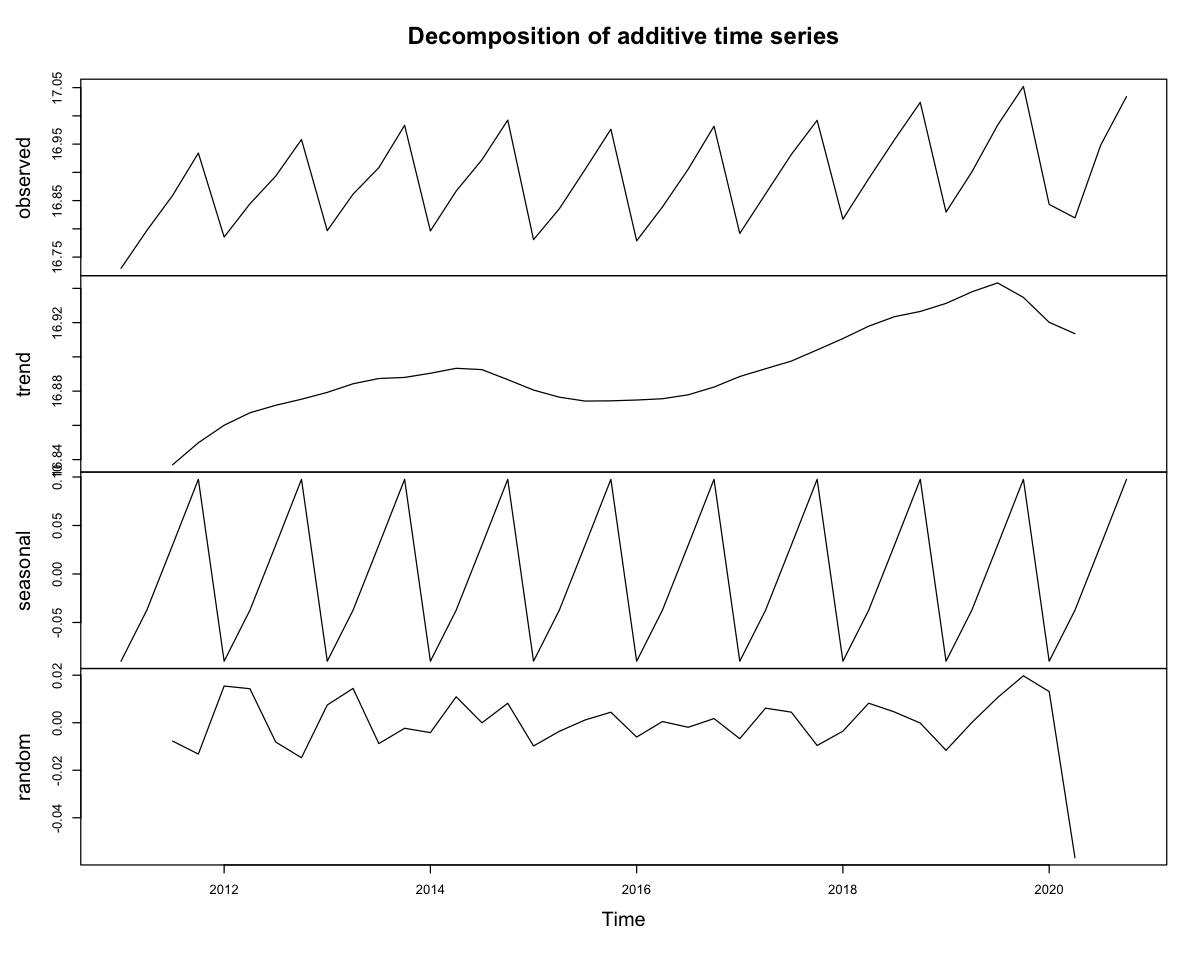

In [8]:
decomp <- decompose(log_gdp_ts)
plot(decomp)

Как видим, наблюдается возрастающий тренд и сезонность с частотой в четыре квартала, что достаточно логично.


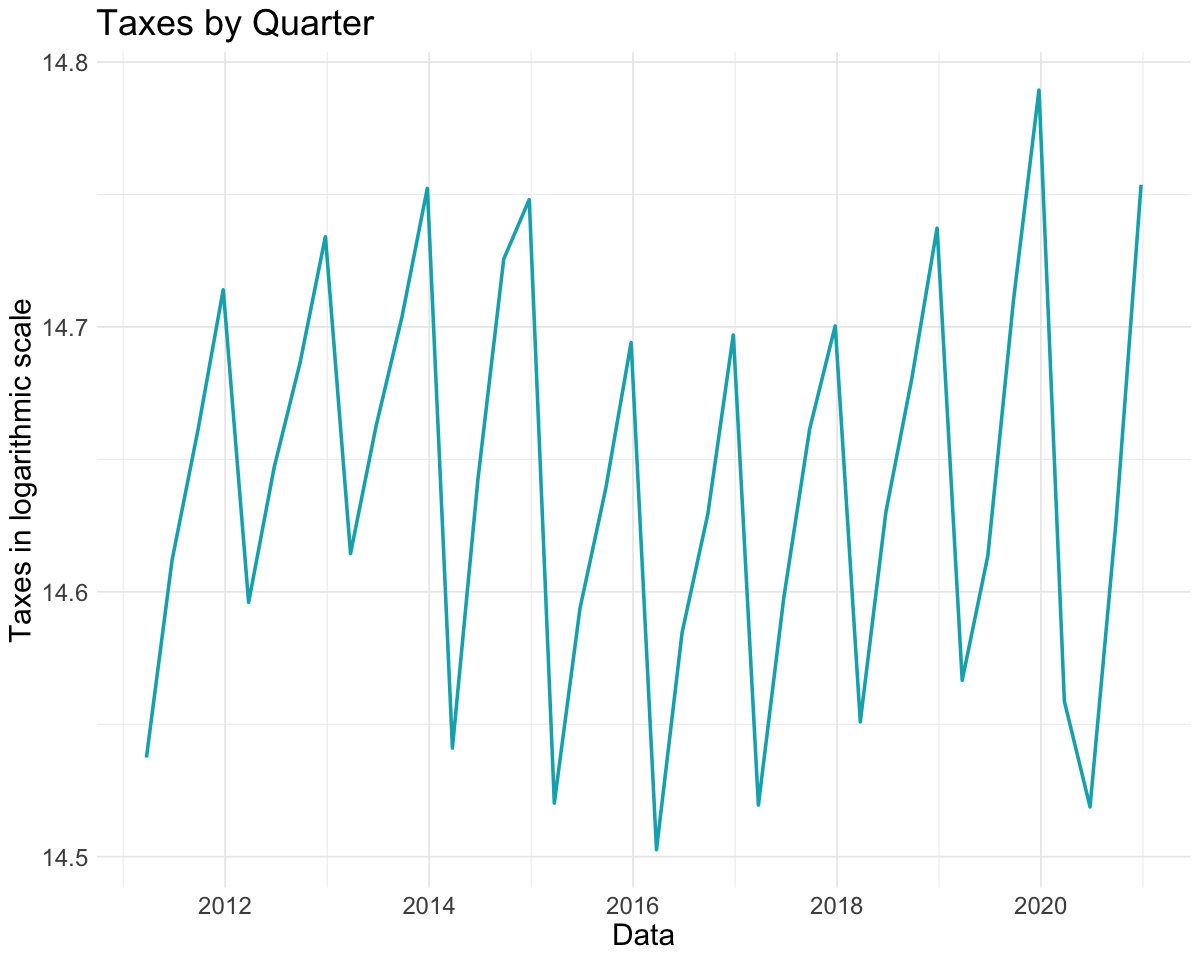

In [9]:
ggplot(data = df, aes(x = date, y = log_taxes))+
  geom_line(color = "#00AFBB", size = 1) + 
    labs(x = "Data",
         y = "Taxes in logarithmic scale", 
         color = "") +
    theme_minimal() + 
    ggtitle("Taxes by Quarter") + 
    theme(text = element_text(size=18))

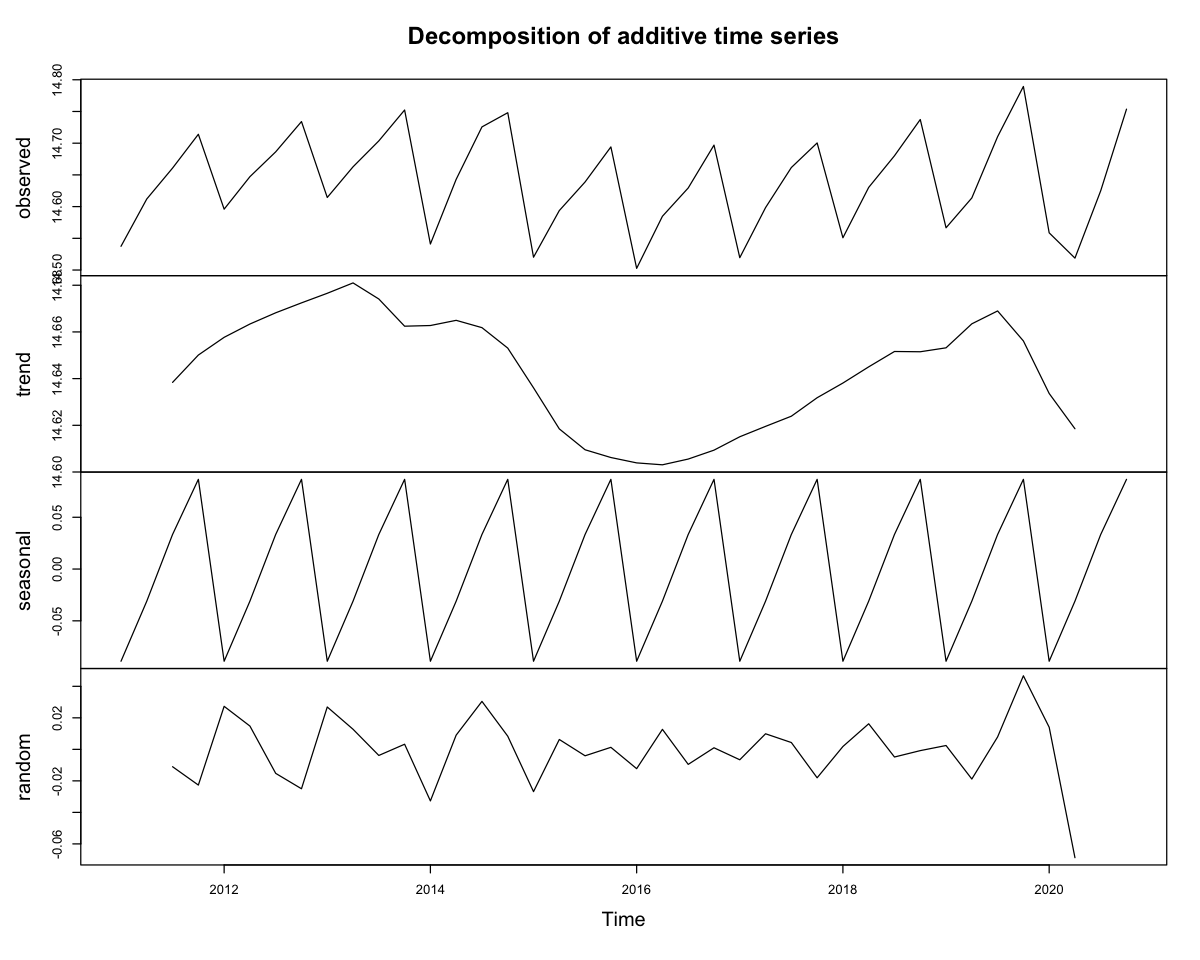

In [10]:
decomp <- decompose(log_taxes_ts)
plot(decomp)

Здесь четкого тренда не наблюдается, однако также видна сезонность частотой в четыре квартала.

### Задание 2

Исследуем, являются ли наши временные ряды стационарными.

Очевидно, наши ряды нестационары, поскольку они являются сезонными. Тем не менее, выполним необходимые пункты задания.

#### ACF и PACF

##### GDP

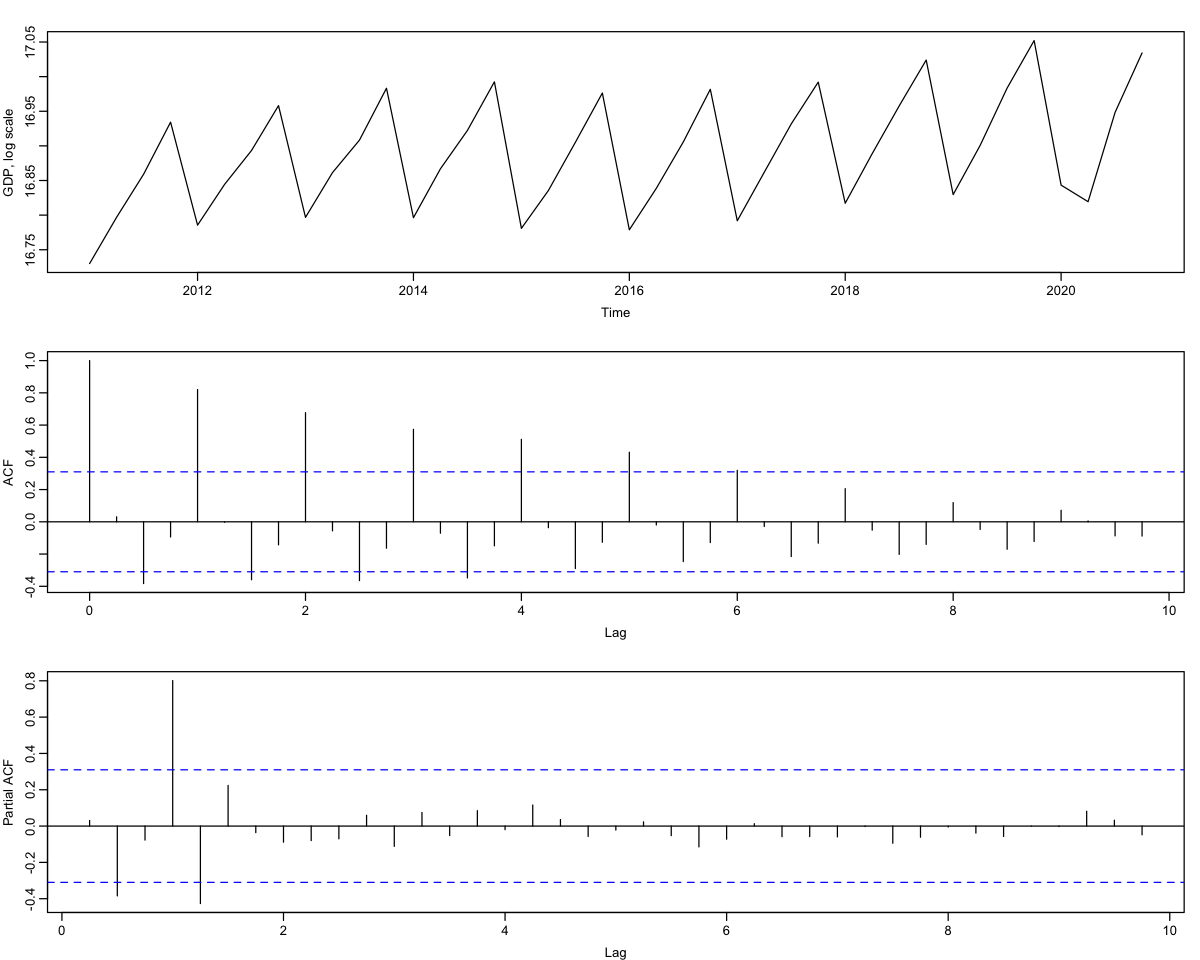

In [11]:
par(mfrow = c(3, 1), mar = c(3, 3, 2, 1), mgp = c(2, 0.6, 0), oma = c(0, 0, 0, 0))
plot(log_gdp_ts, ylab="GDP, log scale"); 
acf(log_gdp_ts, lag.max = 40, main=""); 
pacf(log_gdp_ts, lag.max = 40, main="")

Коррелелограмма ACF достаточно медленно убывает — возможно, ряд нестационарен.

##### Taxes

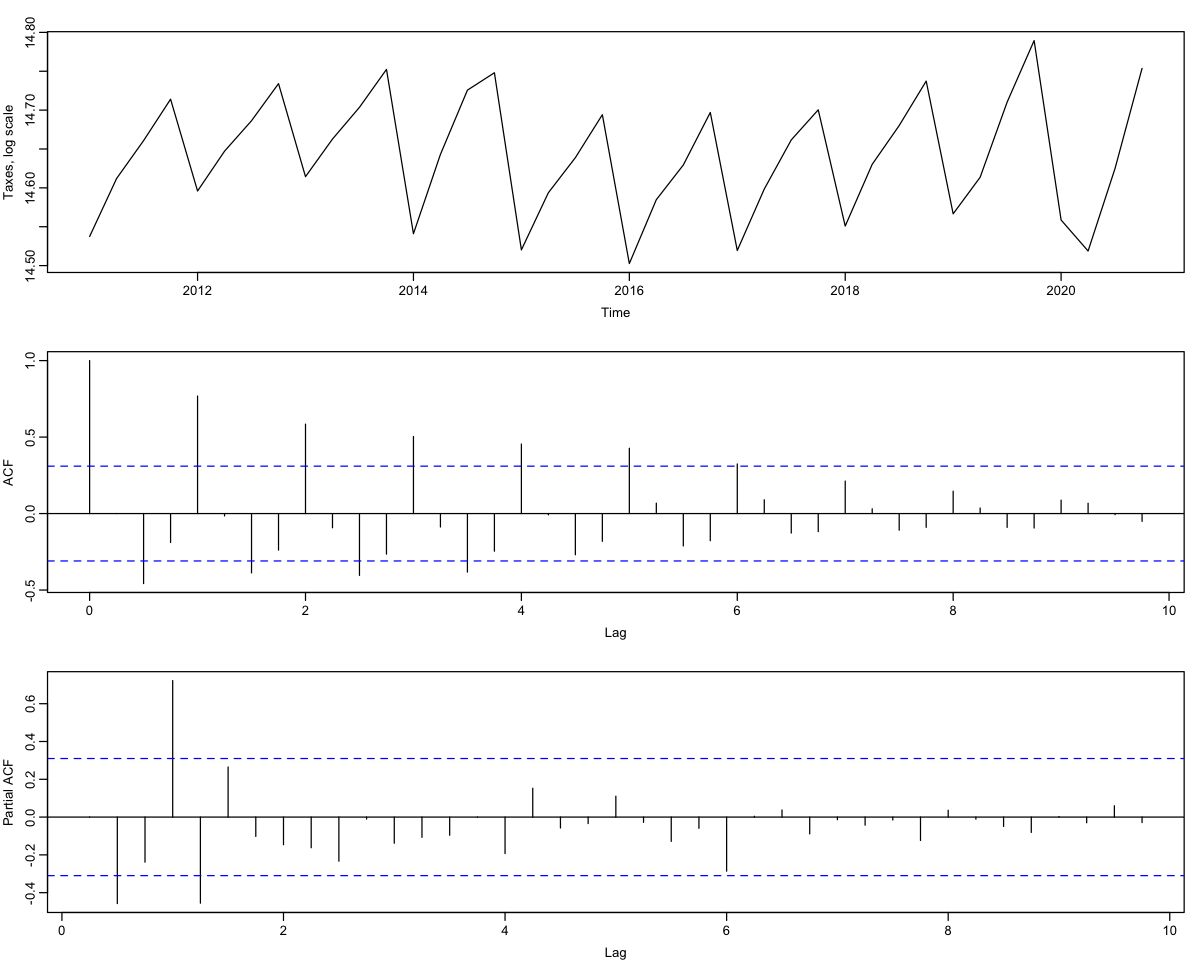

In [12]:
par(mfrow = c(3, 1), mar = c(3, 3, 2, 1), mgp = c(2, 0.6, 0), oma = c(0, 0, 0, 0))
plot(log_taxes_ts, ylab="Taxes, log scale"); 
acf(log_taxes_ts, lag.max = 40, main=""); 
pacf(log_taxes_ts, lag.max = 40, main="")

Коррелелограмма ACF достаточно медленно убывает — возможно, ряд нестационарен.

#### Тесты на наличие единичных корней

Проведем формальную проверку на стационарность рядов.

##### а) Расширенный тест Дикки-Фуллера (ADF)

Полагаем AR(p) процесс:

$$
    y_t = \mu + \phi_1 y_{t-1} + ... + \phi_p y_{t-p} + \varepsilon_t
$$

$$
    \left(1 - \sum\limits_{i=1}^{p}\phi_i L^i \right) y_t = \mu + \varepsilon_t
$$

Полином имеет вид:

$$
    1 - \phi_1 z - \phi_2 z^2 - ... - \phi_p z^p = 0
$$


В ADF-тесте хотим проверить, что $\sum\limits_{i=1}^{p}\phi_i < 1$, ибо тогда временной ряд будет стационарен.

Продифференцируем ряд:

$$\
    \Delta y_t = y_t - y_{t-1} = \mu + \beta y_{t-1} + \zeta_1 \Delta  y_{t-1} + ... + \zeta_{p-1} \Delta  y_{t-p+1},
$$ 
где $\beta = \sum\limits_{i=1}^{p}\phi_i - 1$ и $\zeta_j = -\sum\limits_{i=j+1}^{p}\phi_i$

Вводим следющие гипотезы:

$
\begin{cases}
H_0: \beta = 0 \\ 
H_a: \beta  < 0 
\end{cases}
$

In [13]:
adf.test(log_gdp_ts)


	Augmented Dickey-Fuller Test

data:  log_gdp_ts
Dickey-Fuller = -1.5968, Lag order = 3, p-value = 0.7317
alternative hypothesis: stationary


In [14]:
adf.test(log_taxes_ts)


	Augmented Dickey-Fuller Test

data:  log_taxes_ts
Dickey-Fuller = -1.3429, Lag order = 3, p-value = 0.8314
alternative hypothesis: stationary


Расширенный тест Дикки-Фуллера вывел, что ряды нестационарны.

##### б) KPSS тест

"Contrary to most unit root tests, the presence of a unit root is not the null hypothesis but the alternative."

$
\begin{cases}
H_0: стационарность\\ 
H_a: нестационарность
\end{cases}
$

In [15]:
kpss.test(log_gdp_ts)

Warning message in kpss.test(log_gdp_ts):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  log_gdp_ts
KPSS Level = 0.93073, Truncation lag parameter = 3, p-value = 0.01


In [16]:
kpss.test(log_taxes_ts)

Warning message in kpss.test(log_taxes_ts):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  log_taxes_ts
KPSS Level = 0.13713, Truncation lag parameter = 3, p-value = 0.1


KPSS тест показывает, что первый ряд нестационарен, полагая уровень значимости $\alpha$ равным $5\%$, а второй — наоборот, стационарен.

### Задание 3

Поскольку в общем тесты говорят о нестационарности рядов, приведем их к стационарности.

Поскольку данных временных рядов ярко выделена сезонная компонента, возьмем сезонную разность:

$\Delta^{4} y_t = y_{t} - y_{t-4}$

Если этого будет недостаточно, то также после этого возьмем обычную разность:

$\Delta(\Delta^{4} y_t) = \Delta^{4}y_{t} - \Delta^{4}y_{t-1}$

##### а) GDP

Определим необходимое количество разностей для приведения ряда к стационарности.

In [17]:
nsdiffs(log_gdp_ts)

[1] 1

Берем разность единичного порядка.

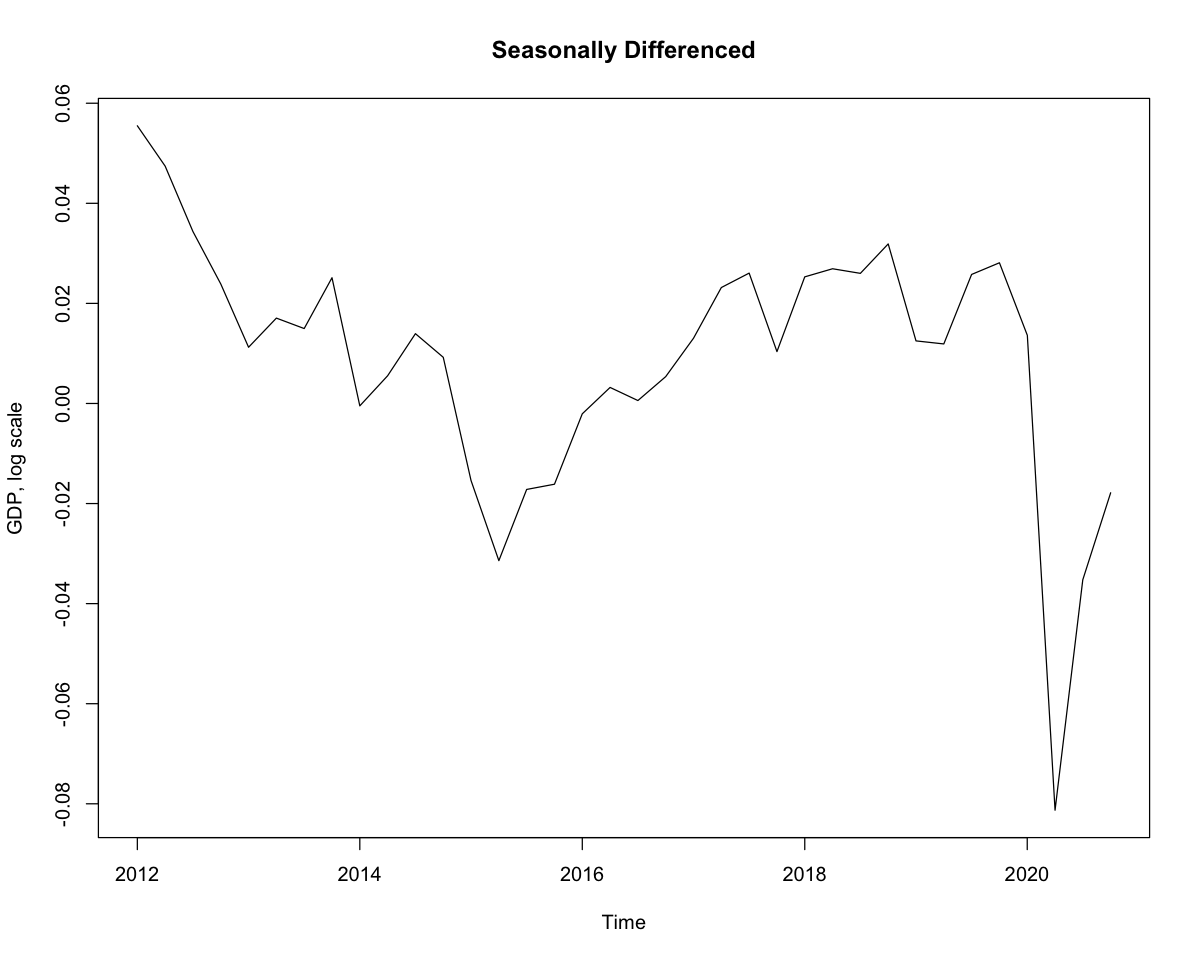

In [18]:
log_gdp_ts_seasdiff <- diff(log_gdp_ts, lag=4, differences=1)
plot(log_gdp_ts_seasdiff, type="l", main="Seasonally Differenced", ylab="GDP, log scale")

Дополнительно взятие обычной разницы не нужно, поскольку:

In [19]:
ndiffs(log_gdp_ts_seasdiff)

[1] 0

##### б) Taxes

In [20]:
nsdiffs(log_taxes_ts)

[1] 1

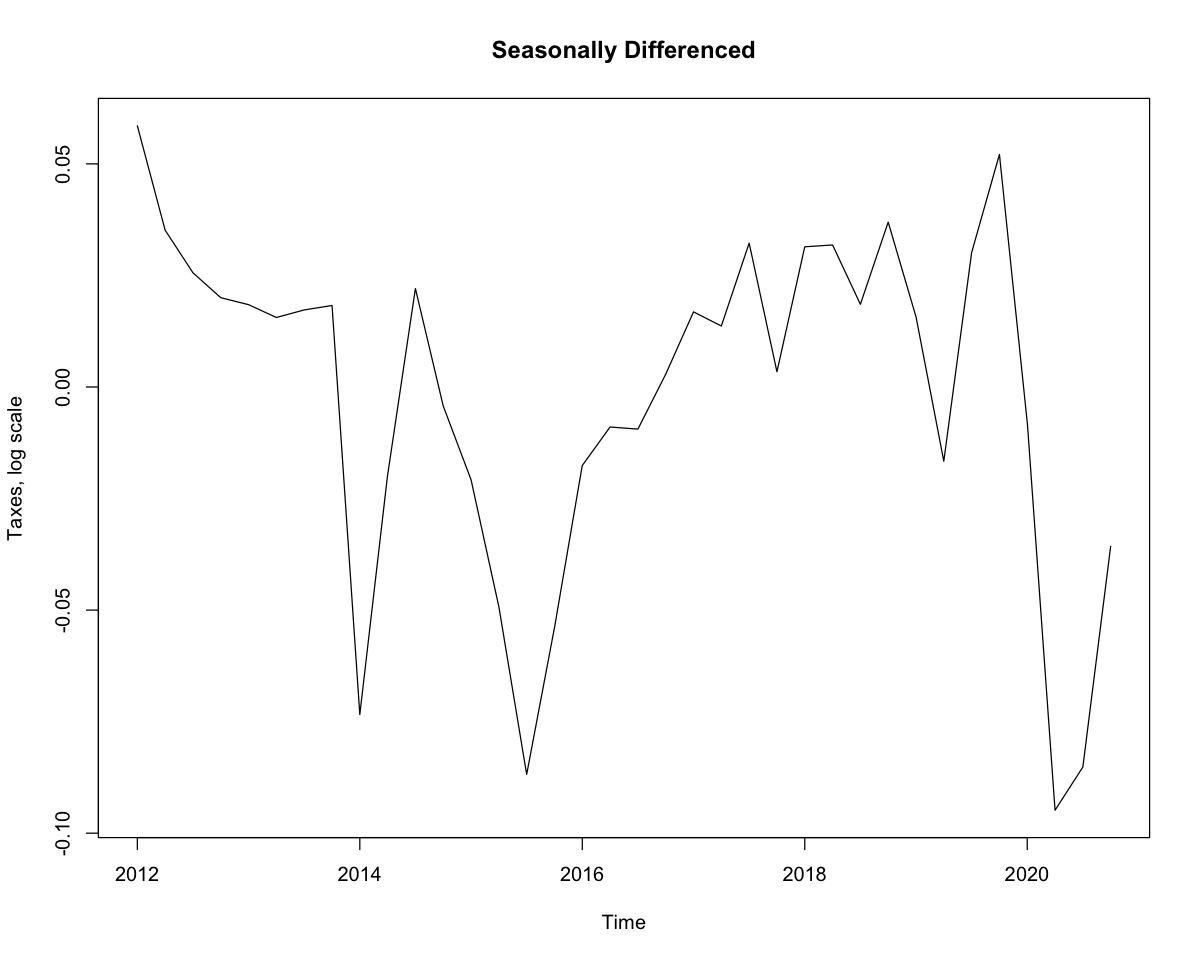

In [21]:
log_taxes_ts_seasdiff <- diff(log_taxes_ts, lag=4, differences=1)
plot(log_taxes_ts_seasdiff, type="l", main="Seasonally Differenced", ylab="Taxes, log scale")

In [22]:
nsdiffs(log_taxes_ts_seasdiff)

[1] 0

### Задание 4

Построим ACF и PACF для стационарных рядов.

Для модели $\text{ARIMA}(p,d,q)$, если $p,q \in \mathbb{N}^*$, то есть если оба порядка ненулевые, ACF и PACF не помогут найти подходящие значения $p$ и $q$.

Однако, для модели $\text{ARIMA}(p,d,0)$ можно найти подходящее значение $p$, а для $\text{ARIMA}(0,d,q)$ — подходящее значение $q$.

##### а) GDP 

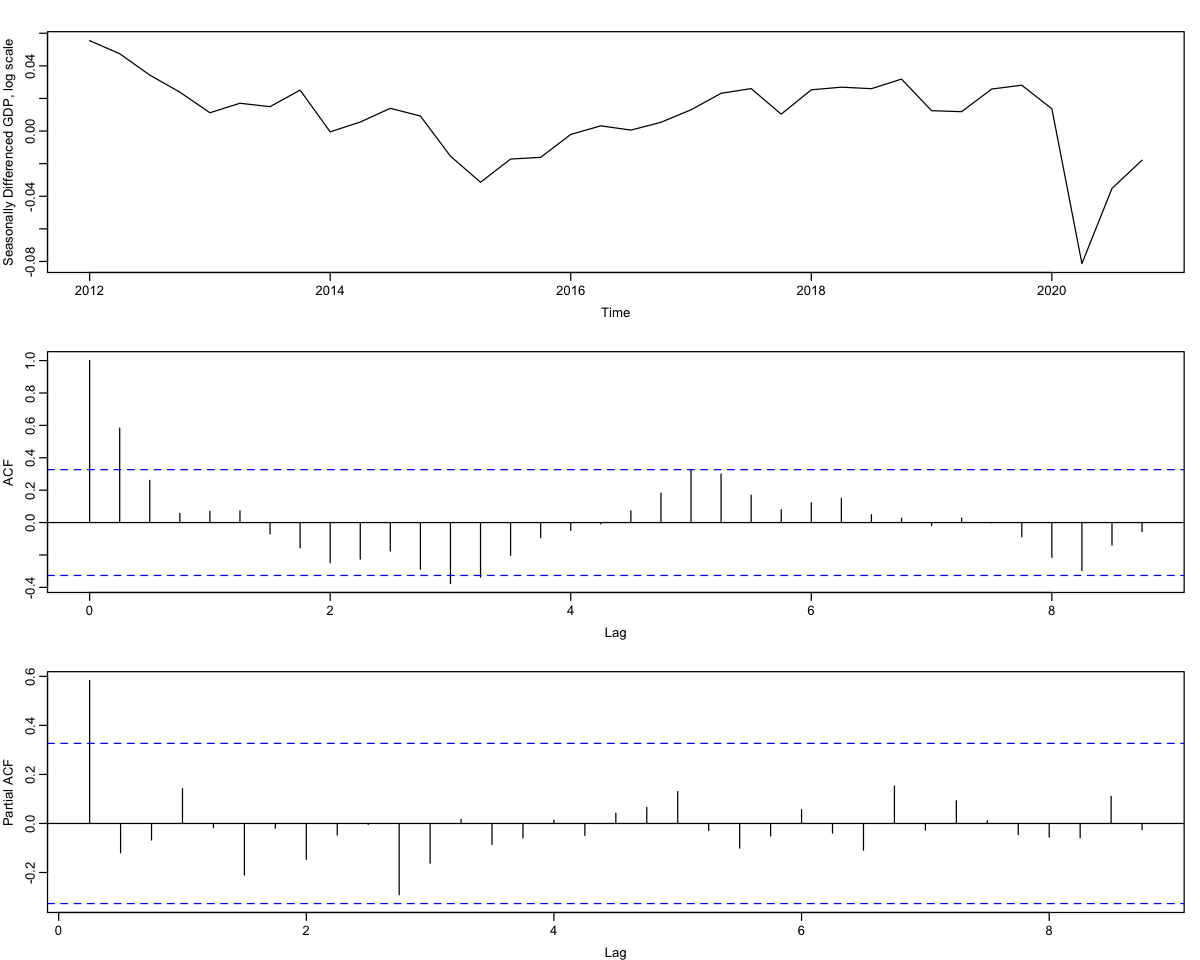

In [23]:
par(mfrow = c(3, 1), mar = c(3, 3, 2, 1), mgp = c(2, 0.6, 0), oma = c(0, 0, 0, 0))
plot(log_gdp_ts_seasdiff, ylab="Seasonally Differenced GDP, log scale"); 
acf(log_gdp_ts_seasdiff, lag.max = 40, main=""); 
pacf(log_gdp_ts_seasdiff, lag.max = 40, main="")

Видно, что здесь $\text{ARMA}(1,0)$, однако еще добавим пару кандидатов: $\text{ARMA}(1,2)$, $\text{ARMA}(0,2)$

In [24]:
arima100_gdp <- Arima(log_gdp_ts_seasdiff, order = c(1, 0, 0), include.constant = TRUE)
summary(arima100_gdp)

Series: log_gdp_ts_seasdiff 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.6480  0.0099
s.e.  0.1342  0.0088

sigma^2 estimated as 0.0003985:  log likelihood=90.58
AIC=-175.15   AICc=-174.4   BIC=-170.4

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.001121989 0.01939971 0.01110993 106.2861 189.5595 0.5328408
                   ACF1
Training set 0.00375415


In [25]:
arima102_gdp <- Arima(log_gdp_ts_seasdiff, order = c(1, 0, 2), include.constant = TRUE)
summary(arima102_gdp)

Series: log_gdp_ts_seasdiff 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
          ar1     ma1    ma2    mean
      -0.2895  1.1499  1.000  0.0104
s.e.   0.1773  0.1089  0.139  0.0066

sigma^2 estimated as 0.0003067:  log likelihood=93.75
AIC=-177.49   AICc=-175.49   BIC=-169.57

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.000401589 0.01651049 0.01193332 37.30675 200.4479 0.5723311
                    ACF1
Training set -0.02746834


In [26]:
arima002_gdp <- Arima(log_gdp_ts_seasdiff, order = c(0, 0, 2), include.constant = TRUE)
summary(arima002_gdp)

Series: log_gdp_ts_seasdiff 
ARIMA(0,0,2) with non-zero mean 

Coefficients:
         ma1     ma2    mean
      1.0201  0.9050  0.0106
s.e.  0.3053  0.3086  0.0084

sigma^2 estimated as 0.0003387:  log likelihood=92.45
AIC=-176.91   AICc=-175.62   BIC=-170.58

Training set error measures:
                        ME     RMSE        MAE      MPE     MAPE      MASE
Training set -0.0004290409 0.017621 0.01269005 37.78368 234.0947 0.6086246
                   ACF1
Training set -0.2192361


##### б) Taxes

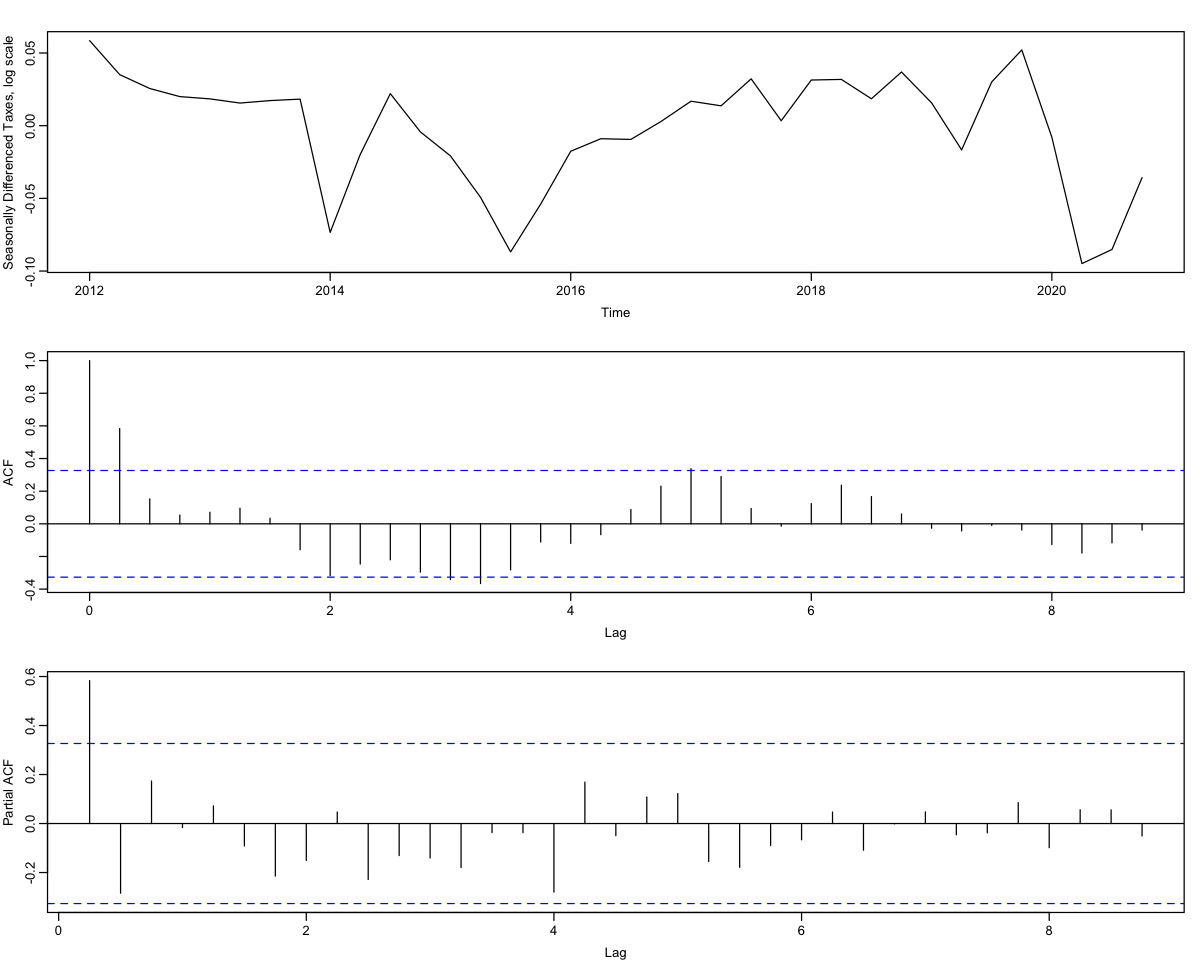

In [27]:
par(mfrow = c(3, 1), mar = c(3, 3, 2, 1), mgp = c(2, 0.6, 0), oma = c(0, 0, 0, 0))
plot(log_taxes_ts_seasdiff, ylab="Seasonally Differenced Taxes, log scale"); 
acf(log_taxes_ts_seasdiff, lag.max = 40, main=""); 
pacf(log_taxes_ts_seasdiff, lag.max = 40, main="")

Такие же кандидаты.

In [28]:
arima100_taxes <- Arima(log_taxes_ts_seasdiff, order = c(1, 0, 0), include.constant = TRUE)
summary(arima100_taxes)

Series: log_taxes_ts_seasdiff 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1     mean
      0.6213  -0.0008
s.e.  0.1336   0.0129

sigma^2 estimated as 0.0009925:  log likelihood=74.18
AIC=-142.36   AICc=-141.61   BIC=-137.61

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.001380527 0.03061609 0.02208419 57.81046 103.9246 0.5802833
                  ACF1
Training set 0.1338441


In [29]:
arima102_taxes <- Arima(log_taxes_ts_seasdiff, order = c(1, 0, 2), include.constant = TRUE)
summary(arima102_taxes)

Series: log_taxes_ts_seasdiff 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1     ma1      ma2     mean
      0.4189  0.4536  -0.0943  -0.0008
s.e.  1.3182  1.3899   1.0707   0.0109

sigma^2 estimated as 0.0009157:  log likelihood=76.55
AIC=-143.11   AICc=-141.11   BIC=-135.19

Training set error measures:
                        ME      RMSE        MAE      MPE     MAPE      MASE
Training set -0.0009112539 0.0285305 0.01966099 41.92186 95.08933 0.5166115
                    ACF1
Training set -0.01903265


In [30]:
arima002_taxes <- Arima(log_taxes_ts_seasdiff, order = c(0, 0, 2), include.constant = TRUE)
summary(arima002_taxes)

Series: log_taxes_ts_seasdiff 
ARIMA(0,0,2) with non-zero mean 

Coefficients:
         ma1     ma2     mean
      0.8680  0.2088  -0.0009
s.e.  0.1621  0.1559   0.0097

sigma^2 estimated as 0.0008918:  log likelihood=76.48
AIC=-144.96   AICc=-143.67   BIC=-138.62

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.0007356618 0.02859182 0.02030556 44.36509 97.41222 0.5335482
                     ACF1
Training set -0.009631966


### Задание 5

__Информационный критерий Акаике__ имеет вид:

$$
    AIC = 2k - \  2 \ln \mathcal{L},
$$ 

где $\ln \mathcal{L}$ — максимизированный логарифм правдоподобия, $k$ — число параметров модели.

AIC не только вознаграждает за качество приближения, но и штрафует за использование излишнего количества параметров модели. Абсолютное значение AIC не имеет смысла: он указывает только на относительный порядок сравниваемых моделей. Наилучшей будет модель с наименьшим значением критерия Акаике. 

__Байесовский информационный критерий__ имеет вид:

$$
    BIC = \ln(nk) - \  2 \ln \mathcal{L},
$$

где $n$ — количество наблюдений в выборке

BIC является аналогом AIC с более строгой функцией штрафа.

##### а) GDP

In [31]:
c(arima100_gdp$aic, arima102_gdp$aic, arima002_gdp$aic)

[1] -175.1517 -177.4913 -176.9095

In [32]:
c(arima100_gdp$bic, arima102_gdp$bic, arima002_gdp$bic)

[1] -170.4011 -169.5737 -170.5755

Поскольку критерии информативности дают несогласованные друг с другом результаты, выберем модель по AIC.

Получается, лучше всего подходит $\text{ARMA}(1,0)$.

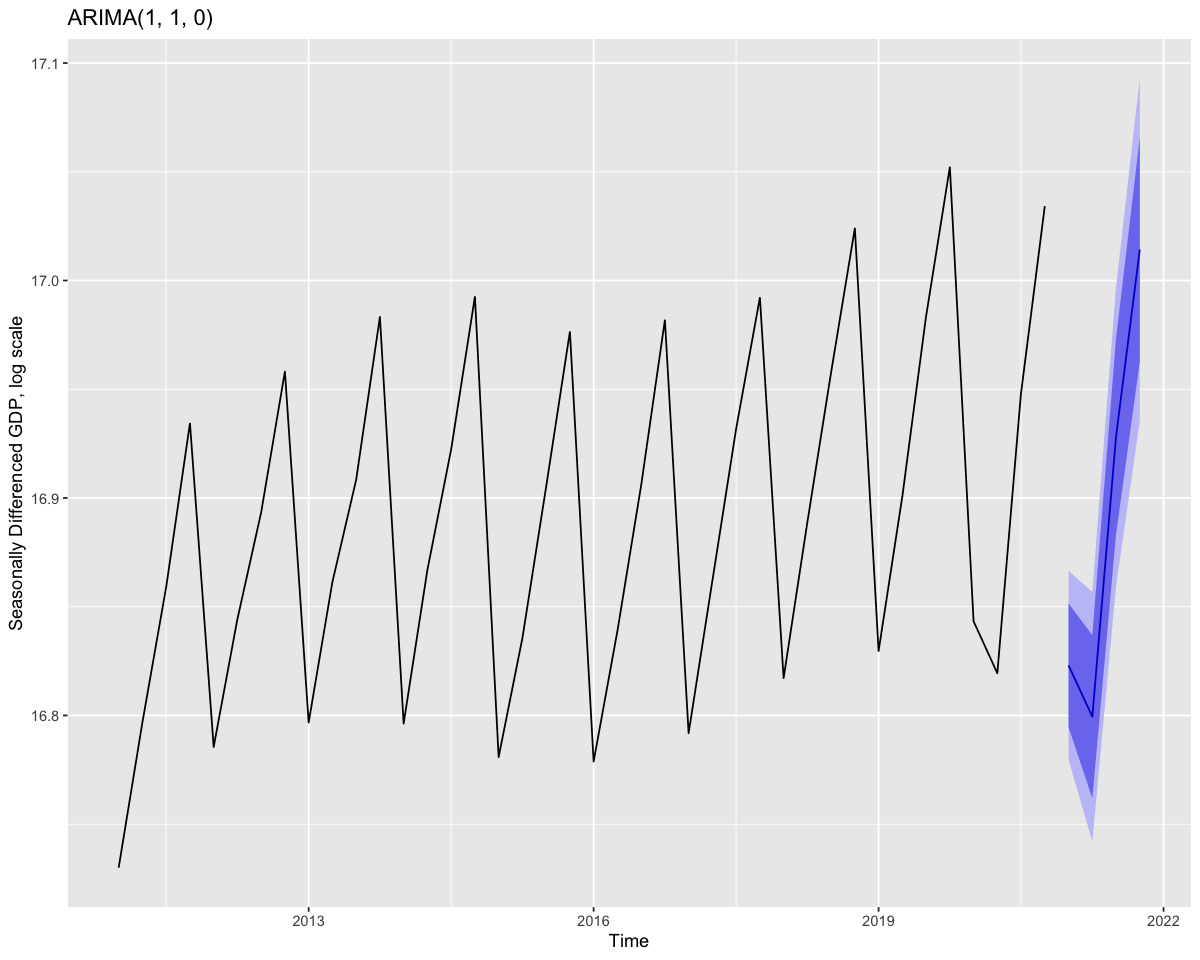

In [33]:
# Используем ARIMA(1,0,0)(0,1,0)[4] для исходного нестационарного ряда, чтобы именно для него получить прогнозы
sarima110_gdp <- Arima(log_gdp_ts, order = c(1, 1, 0), seasonal=c(0, 1, 0), include.constant = TRUE)
future <- forecast(sarima110_gdp, h = 4)
autoplot(future, main="ARIMA(1, 1, 0)", ylab="Seasonally Differenced GDP, log scale")

Оцененные параметры модели:

In [34]:
sarima110_gdp$coef

ar1 
-0.1404253

##### б) Taxes

In [35]:
c(arima100_taxes$aic, arima102_taxes$aic, arima002_taxes$aic)

[1] -142.3572 -143.1050 -144.9561

In [36]:
c(arima100_taxes$bic, arima102_taxes$bic, arima002_taxes$bic)

[1] -137.6066 -135.1874 -138.6220

Здесь также лучше всего подходит $\text{ARMA}(1,0)$.

Оцененные параметры модели:

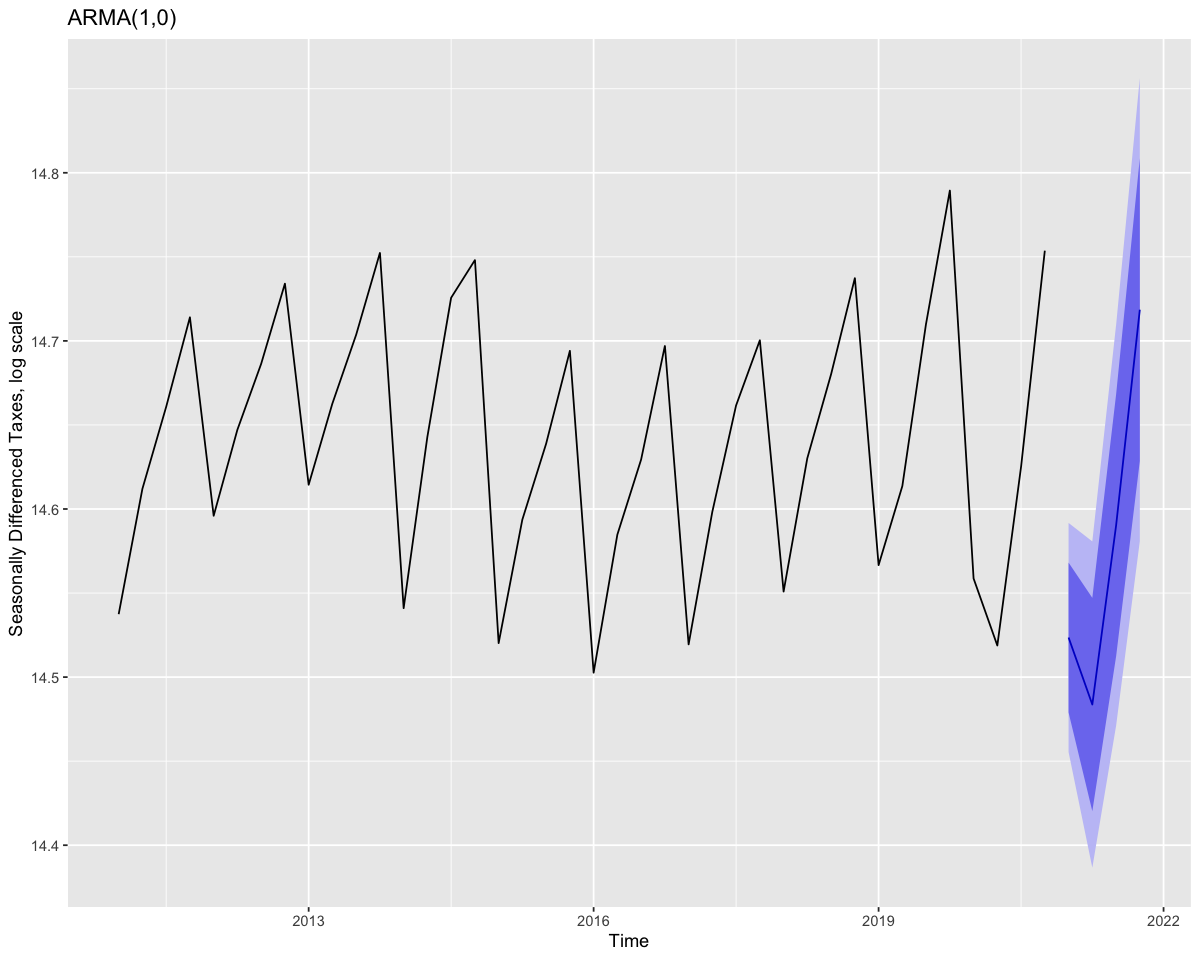

In [37]:
# Используем ARIMA(1,0,0)(0,1,0)[4] для исходного нестационарного ряда, чтобы именно для него получить прогнозы
sarima110_taxes <- Arima(log_taxes_ts, order = c(1, 1, 0), seasonal=c(0, 1, 0), include.constant = TRUE)
future <- forecast(sarima110_taxes, h = 4)
autoplot(future, main="ARMA(1,0)", ylab="Seasonally Differenced Taxes, log scale")

In [38]:
sarima110_taxes$coef

ar1 
0.01294393

### Задание 6

Проверим остатки выбранных моделей на отсутствие автокорреляции с помощью теста Льюнга-Бокса:

$
\begin{cases}
H_0: \rho_1 = ... = \rho_k = 0\\ 
H_a: \rho_i \neq 0, \ i \in {1, ..., k}
\end{cases}
$

Тестовая статистика:

$$
    LB_{obs} = n(n + 1)\sum\limits_{k=1}^h \dfrac{\hat\rho_k^2}{n - k} \sim \chi^2(h)
$$

Мы оценивали $\text{ARMA}(1,0)$ модель, поэтому степени свободы падают на $p+q=1$. Указываем значение аргумента `fitdf` равное $1$. Для сезонных рядов рекомендуется брать `lag` равным $h=2m$, где $m$ — частотность ряда.

In [39]:
resid_sarima110_gdp <- resid(sarima110_gdp)
Box.test(resid_sarima110_gdp, lag = 8, type = "Ljung-Box", fitdf=1)


	Box-Ljung test

data:  resid_sarima110_gdp
X-squared = 5.4386, df = 7, p-value = 0.6066


In [40]:
resid_sarima110_taxes <- resid(sarima110_taxes)
Box.test(resid_sarima110_taxes, lag = 8, type = "Ljung-Box", fitdf=1)


	Box-Ljung test

data:  resid_sarima110_taxes
X-squared = 10.272, df = 7, p-value = 0.1737


Как видим, гипотеза о «белошумности» остатков временных рядов не отвергается.

## Часть 2

Поскольку выбранные времянные ряды являются стационарными только после взятия разности первого порядка, имеем:

$$
    \ln GDP_t \sim I(1), \ \ln Taxes_t \sim I(1)
$$


Проверим, являются ли два этих ряда коинтегрированными, то есть:

$$
    Z_t = \ln GDP_t + \ln Taxes_t \sim I(0)
$$

Можем построить МНК регрессию:

$$
    \ln GDP_t = \beta_0 + \beta_1\ln Taxes_t + \varepsilon_t
$$

Наши ряды будут коинтегрированными, если ряд $\varepsilon_t$ будет стационарным. Поэтому будем проверять остатки регрессии $\hat \varepsilon_t$ на стационарность.

In [41]:
lr <- lm(diff(log_gdp) ~ diff(log_taxes), data = df)
lr_res_ts <- ts(residuals(lr), freq = 4)

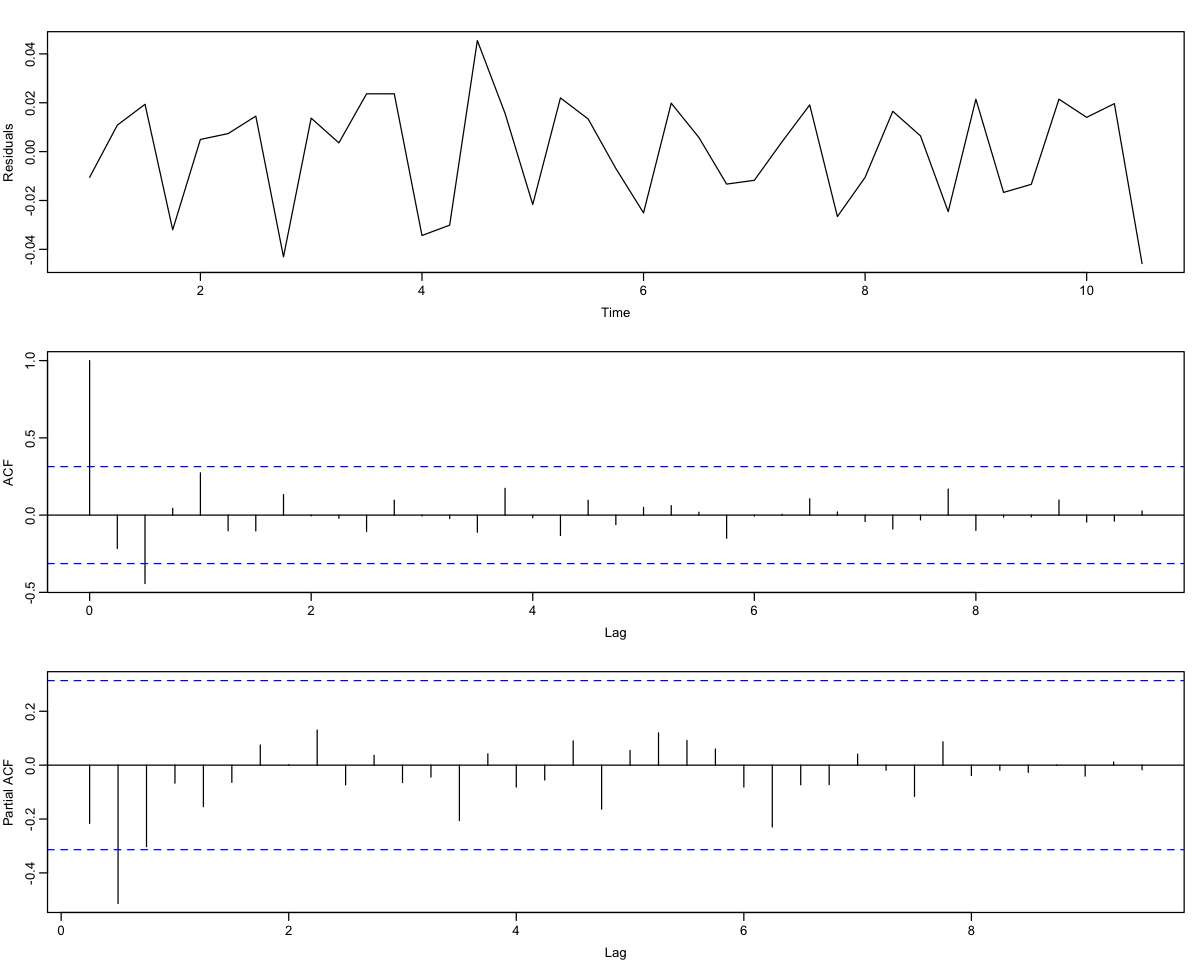

In [42]:
par(mfrow = c(3, 1), mar = c(3, 3, 2, 1), mgp = c(2, 0.6, 0), oma = c(0, 0, 0, 0))
plot(lr_res_ts, ylab="Residuals"); 
acf(lr_res_ts, lag.max = 40, main=""); 
pacf(lr_res_ts, lag.max = 40, main="")

Коррелелограмма достаточно быстро убывает. Однако, проведем формальный тест.

In [43]:
adf.test(lr_res_ts)

Warning message in adf.test(lr_res_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  lr_res_ts
Dickey-Fuller = -4.3612, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


ADF показывает, что временной ряд из остатков МНК регрессии стационарен. Значит, два наших исходных ряда коинтегрированы.